<h1><center>IE 313 Time Series Analysis: Code Implementation Assignment 2</center></h1>

<div align="right">2022 Fall, Prof. Yongjae Lee</div>
<div align="right"> Coded by TA. Seyoung Kim</div>
<div align="right"> abc21389@unist.ac.kr</div>

<h1>Table of Contents<span class="tocSkip"></span></h1>

[1. Library load](#Library-load)

[2. Data load and pre-processing](#Data-load)

[3. Test for stationarity](#Test-for-stationarity)

[4. Transformation and Checking the Stationarity](#Transformation-and-Checking-the-Stationarity)

[5. Estimation for ARIMA model order](#Estimation-for-ARIMA-model-order)

[6. Residual Analysis](#Residual-Analysis)

[7. Forecasting with our model](#Forecasting-with-our-model)

<h2>Library load<h2>

install the required packages using pip
* Install using pip : `pandas`, `scipy`, `matplotlib`, `statsmodels`,`pmdarima`

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<h2>Data load<h2>

<h3> The sample data 'Electric_Production.csv' is the average monthly production of electricity from 1985-01 to 2018-01.<h3>

In [2]:
df = pd.read_csv('Electric_Production.csv')
df
df['DATE'] = pd.to_datetime(df['DATE']) # To convert dtype column 'DATE'
df = df.set_index('DATE')
df.head()
# Datasource : https://www.kaggle.com/datasets/shenba/time-series-datasets

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [3]:
df.rename(columns={'IPG2211A2N':'value'}, inplace=True) # To convert column name
df.head()

,value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [4]:
df.index #check dtype of index, it should be 'datetime64[ns]'

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='DATE', length=397, freq=None)

<AxesSubplot:xlabel='DATE'>

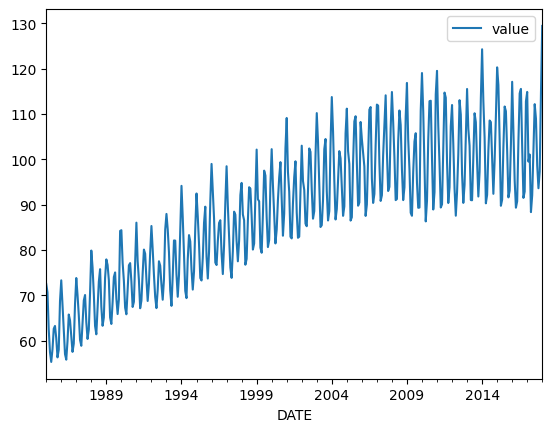

In [5]:
df.plot()

**Preceed with time-series decomposition of the data.**

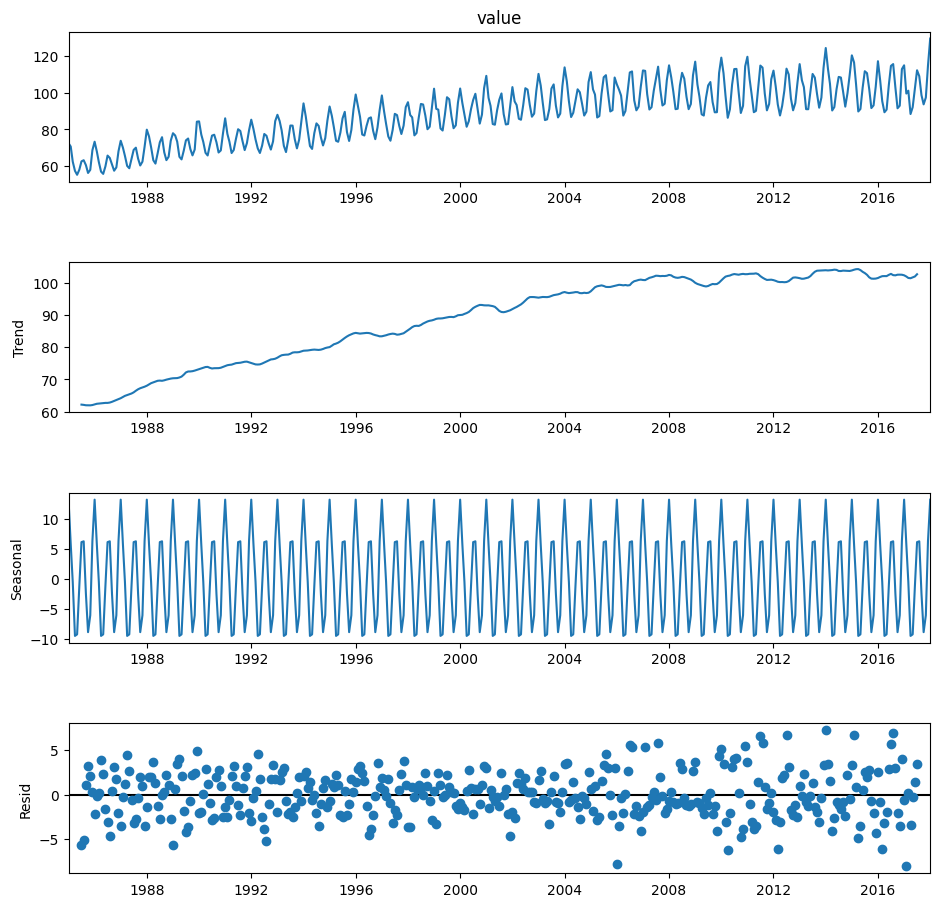

In [6]:
decomposition= sm.tsa.seasonal_decompose(df['value'], model='additive')

ax = decomposition.plot()
ax.set_size_inches(10,10)

plt.show()


**From above we can clearly see that our data is having a seasonality and having an increasing trend.**

<h3>Test for stationarity<h3>

**There is another way to check the stationarity of the time series data.**

**Check whether your data is stationary or not using ACF, PACF distribution.**

In [7]:
# time-series analysis plots

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

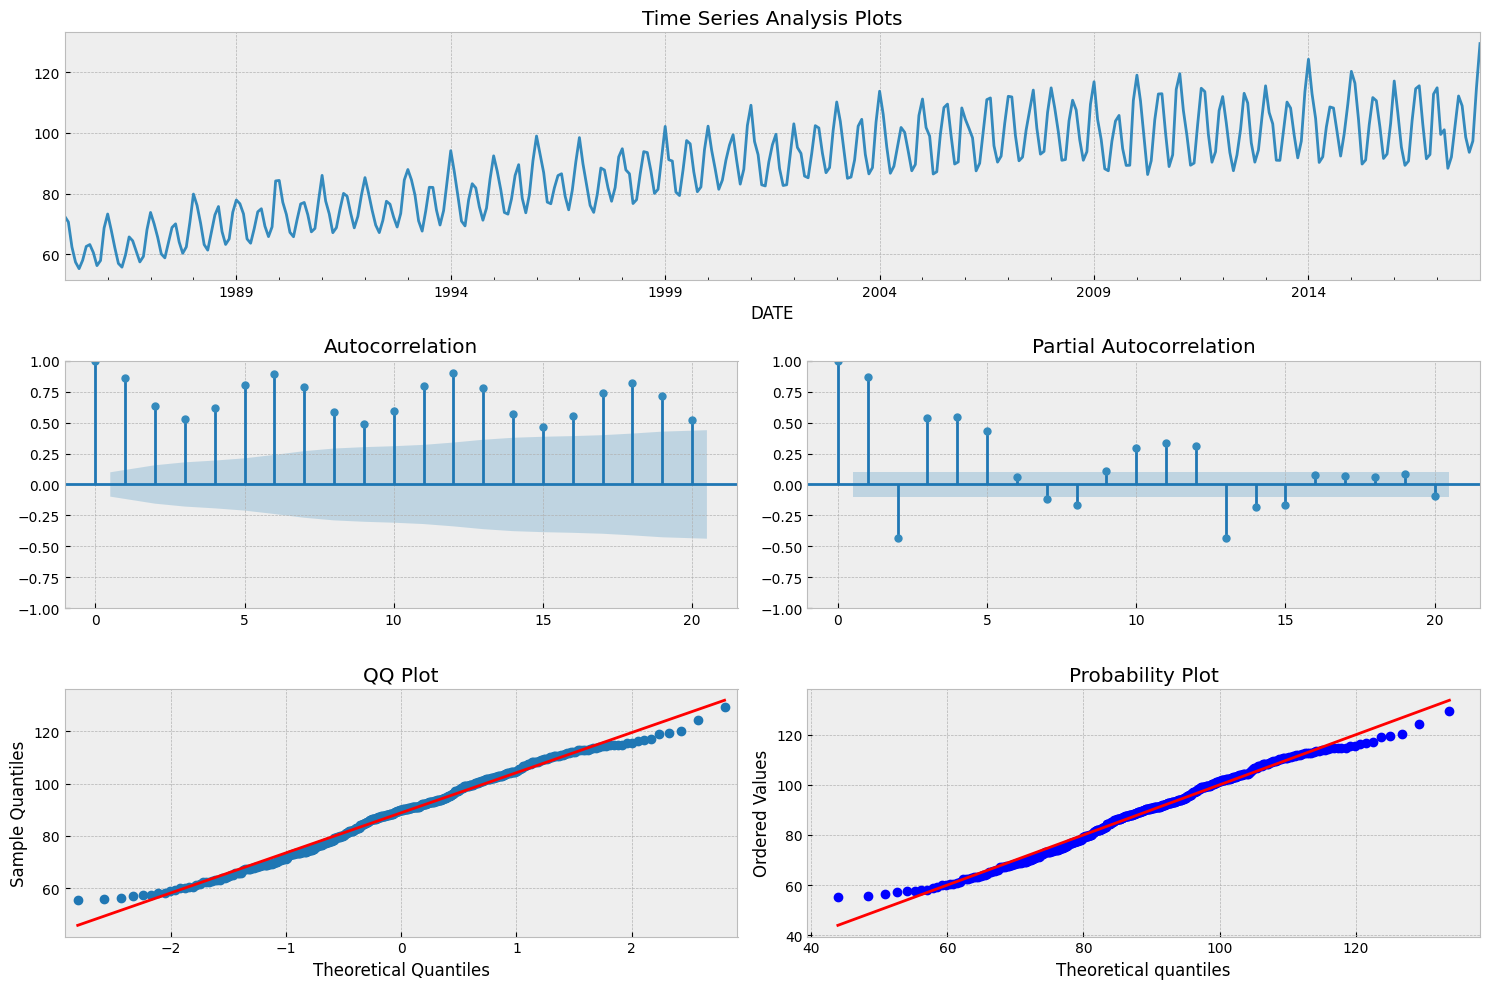

In [8]:
raw_data = tsplot(df['value'], lags=20)

**We can estimate that the raw data are non-stationary by seeing that they have ACF positive autocorrelation and PACF are gradually decreasing.**

**We need to make it stationary by transformation.**

<h3>Transformation and Checking the Stationarity<h3>

<h3>First-Differencing<h3>

**We can use first-difference method to remove trend.**

In [9]:
#1st diffrence
diff_df = df['value'].diff(periods=1).iloc[1:]

print('Raw data')
print(df)

print('After 1st difference')
print(diff_df)

Raw data
               value
DATE                
1985-01-01   72.5052
1985-02-01   70.6720
1985-03-01   62.4502
1985-04-01   57.4714
1985-05-01   55.3151
...              ...
2017-09-01   98.6154
2017-10-01   93.6137
2017-11-01   97.3359
2017-12-01  114.7212
2018-01-01  129.4048

[397 rows x 1 columns]
After 1st difference
DATE
1985-02-01    -1.8332
1985-03-01    -8.2218
1985-04-01    -4.9788
1985-05-01    -2.1563
1985-06-01     2.7753
               ...   
2017-09-01   -10.3158
2017-10-01    -5.0017
2017-11-01     3.7222
2017-12-01    17.3853
2018-01-01    14.6836
Name: value, Length: 396, dtype: float64


<AxesSubplot:xlabel='DATE'>

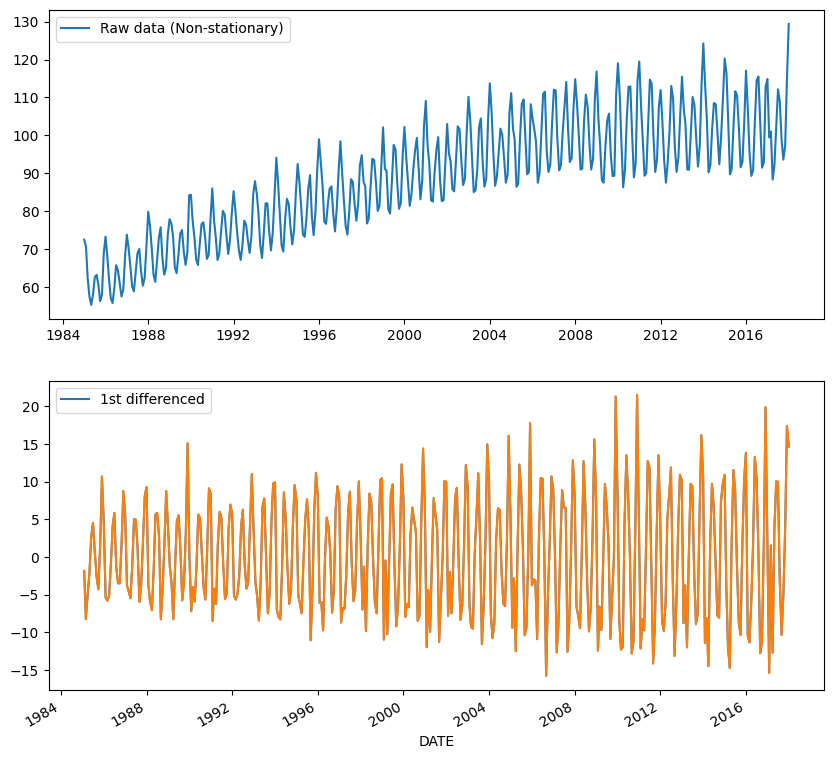

In [10]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(211)
ax1.plot(df['value'])
ax1.legend(['Raw data (Non-stationary)'])

ax2 =plt.subplot(212)
ax2.plot(diff_df)
ax2.legend(['1st differenced'])

diff_df.plot()

**After first-differencing, it looks quite stationary compared with the original data.**

**To make sure that the data have become stationary through the 1st differencing, we use the ADF (Augmented Dickey Fuller) test.**

* The null hypothesis (H0) of the Augmented Dickkey Fuller Test is "the data does not have stationarity", and the alternative hypothesis (H1) is "the data has stationarity".


* If the ADF statistic is greater than critical value, it means that the data is non-stationary, and if it is less than critical value, it means that the data is stationary.


* If the p-value is greater than 0.05, it means that the data is non-stationary, and if it is less than 0.05, it means that the data is stationary.

In [11]:
# ADF test

adf_test = adfuller(diff_df)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])

ADF Statistic: -7.104891
Critical Values @ 0.05: -2.87
p-value: 0.00000000040777865655


**The ADF statistic is less than critical values. Also, the p-value is nearly 0 and it is less than 0.05.**

**After 1st differencing, our data looks stationary. Then, let's try 2nd differencing to our data.**

<h3> Second differencing<h3>

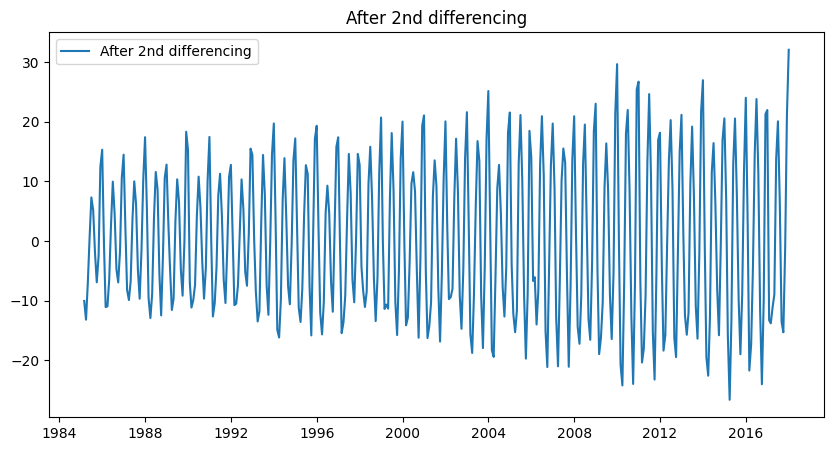

In [12]:
#2nd difference
diff_2_df = df['value'].diff(periods=2).iloc[2:]

plt.figure(figsize=(10,5))
plt.plot(diff_2_df, label='After 2nd differencing')
plt.legend(loc='best')
plt.title('After 2nd differencing')
plt.show()

In [13]:
diff_2_df.head() #the upper 2 months are removed.

DATE
1985-03-01   -10.0550
1985-04-01   -13.2006
1985-05-01    -7.1351
1985-06-01     0.6190
1985-07-01     7.3051
Name: value, dtype: float64

In [14]:
# ADF test

adf_test = adfuller(diff_2_df)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])

ADF Statistic: -7.197851
Critical Values @ 0.05: -2.87
p-value: 0.00000000024083609624


**Therefore, the p-value is 2.4083609623608695e-10, less than 0.05. So it is stationary.**


<h3> Logarithm<h3>

**Next, let's use a log transformation method to keep the variation width of our data constant.**

In [15]:
df_log = np.log(df['value'])

#1st differencing with logarithm
diff_df_log = df_log.diff(periods=1).iloc[1:]

#2nd differencing with logarithm
diff_2_df_log = df_log.diff(periods=2).iloc[2:]


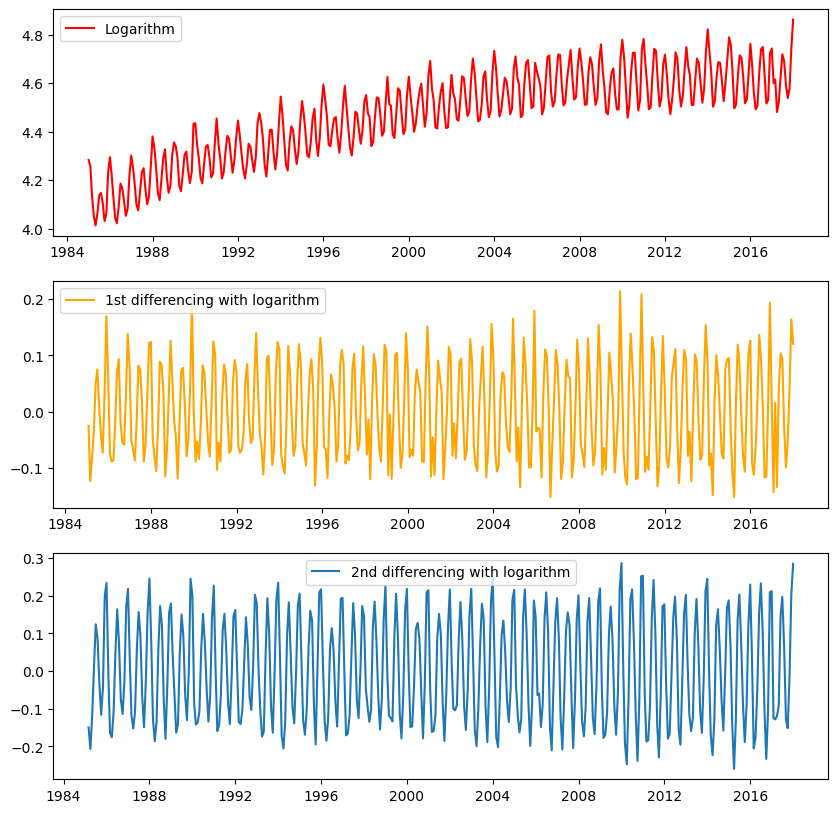

In [16]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(311)
ax1.plot(df_log, color='red')
ax1.legend(['Logarithm'])


ax2 = plt.subplot(312)
ax2.plot(diff_df_log, color='orange')
ax2.legend(['1st differencing with logarithm'])

ax3 =plt.subplot(313)
ax3.plot(diff_2_df_log)
ax3.legend(['2nd differencing with logarithm'])


In [17]:
# ADF test

adf_test = adfuller(diff_df_log)
adf_test_ = adfuller(diff_2_df_log)

print('---1st differencing with logarithm---')
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])


print('\n---2nd differencing with logarithm---')
print('ADF Statistic: %f' % adf_test_[0])
print('Critical Values @ 0.05: %.2f' % adf_test_[4]['5%'])
print('p-value: %20.20f' % adf_test_[1])

---1st differencing with logarithm---
ADF Statistic: -6.748333
Critical Values @ 0.05: -2.87
p-value: 0.00000000299516149812

---2nd differencing with logarithm---
ADF Statistic: -6.844641
Critical Values @ 0.05: -2.87
p-value: 0.00000000175546089375


**When we differenced our data after log transformation, both results of ADF test seem to stationary.**

<h3> Box-Cox transformation<h3>

**There is another way to transform data stationary. The Box-Cox transformation is a flexible data transformation technique that supports a number of related transforms, including square root and log transformations.**

In [18]:
df_boxcox = df.copy()

Optimal Lambda: 1.0748351764172541


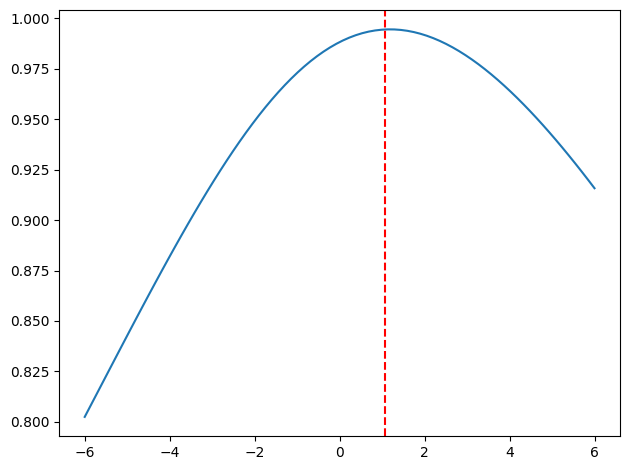

In [19]:
# Parameter estimation of Box-Cox transformation


#Select the lambda (l_opt) with the highest normality by changing the lambda in a specific range (x) of the normal distribution
x, y = sp.stats.boxcox_normplot(df_boxcox.value, la=-6, lb=6) #Normalization Range (-6 ~ 6)

#Returns y and x values converted to normal distribution
y_transfer, l_opt = sp.stats.boxcox(df_boxcox.value)

print('Optimal Lambda:', l_opt)

plt.plot(x,y)
plt.axvline(x=l_opt, color='r', ls='--')
plt.tight_layout()
plt.show()

In [20]:
# we use box-cox transformation with optimal lambda = 1.0748351764172541
df_boxcox['value'] = boxcox(df['value'],lmbda=1.0748351764172541)

df_boxcox.head()

,value
DATE,
1985-01-01,92.019399
1985-02-01,89.495821
1985-03-01,78.239699
1985-04-01,71.476331
1985-05-01,68.560510


In [43]:
#1st differencing with Box-Cox
diff_df_boxcox = df_boxcox.diff(periods=1).iloc[1:]

#2nd differencing with Box-Cox
diff_2_df_boxcox = df_boxcox.diff(periods=2).iloc[2:]

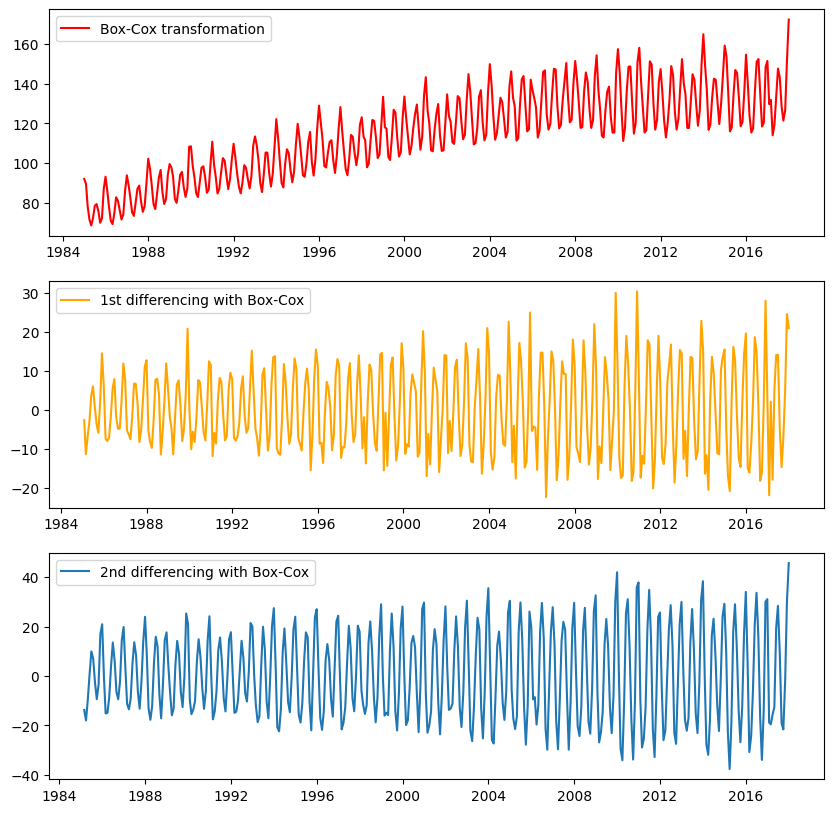

In [44]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(311)
ax1.plot(df_boxcox, color='red')
ax1.legend(['Box-Cox transformation'])


ax2 = plt.subplot(312)
ax2.plot(diff_df_boxcox, color='orange')
ax2.legend(['1st differencing with Box-Cox'])

ax3 =plt.subplot(313)
ax3.plot(diff_2_df_boxcox)
ax3.legend(['2nd differencing with Box-Cox'])

In [45]:
# ADF test

adf_test = adfuller(diff_df_boxcox)
adf_test_ = adfuller(diff_2_df_boxcox)

print('---1st differencing with Box-Cox---')
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])


print('\n---2nd differencing with Box-Cox---')
print('ADF Statistic: %f' % adf_test_[0])
print('Critical Values @ 0.05: %.2f' % adf_test_[4]['5%'])
print('p-value: %20.20f' % adf_test_[1])

---1st differencing with Box-Cox---
ADF Statistic: -7.122470
Critical Values @ 0.05: -2.87
p-value: 0.00000000036920049907

---2nd differencing with Box-Cox---
ADF Statistic: -7.215149
Critical Values @ 0.05: -2.87
p-value: 0.00000000021829546957


**So far, we have used several methods to make the data stationary, such as difference, logarithm, and box-cox transformation.**

**Our data has been stationary after all the transformation, so you can choose one of these when you use the model later.**

***As an example, we will use the <U>1st difference with logarithm</U> in the model.***

1st difference


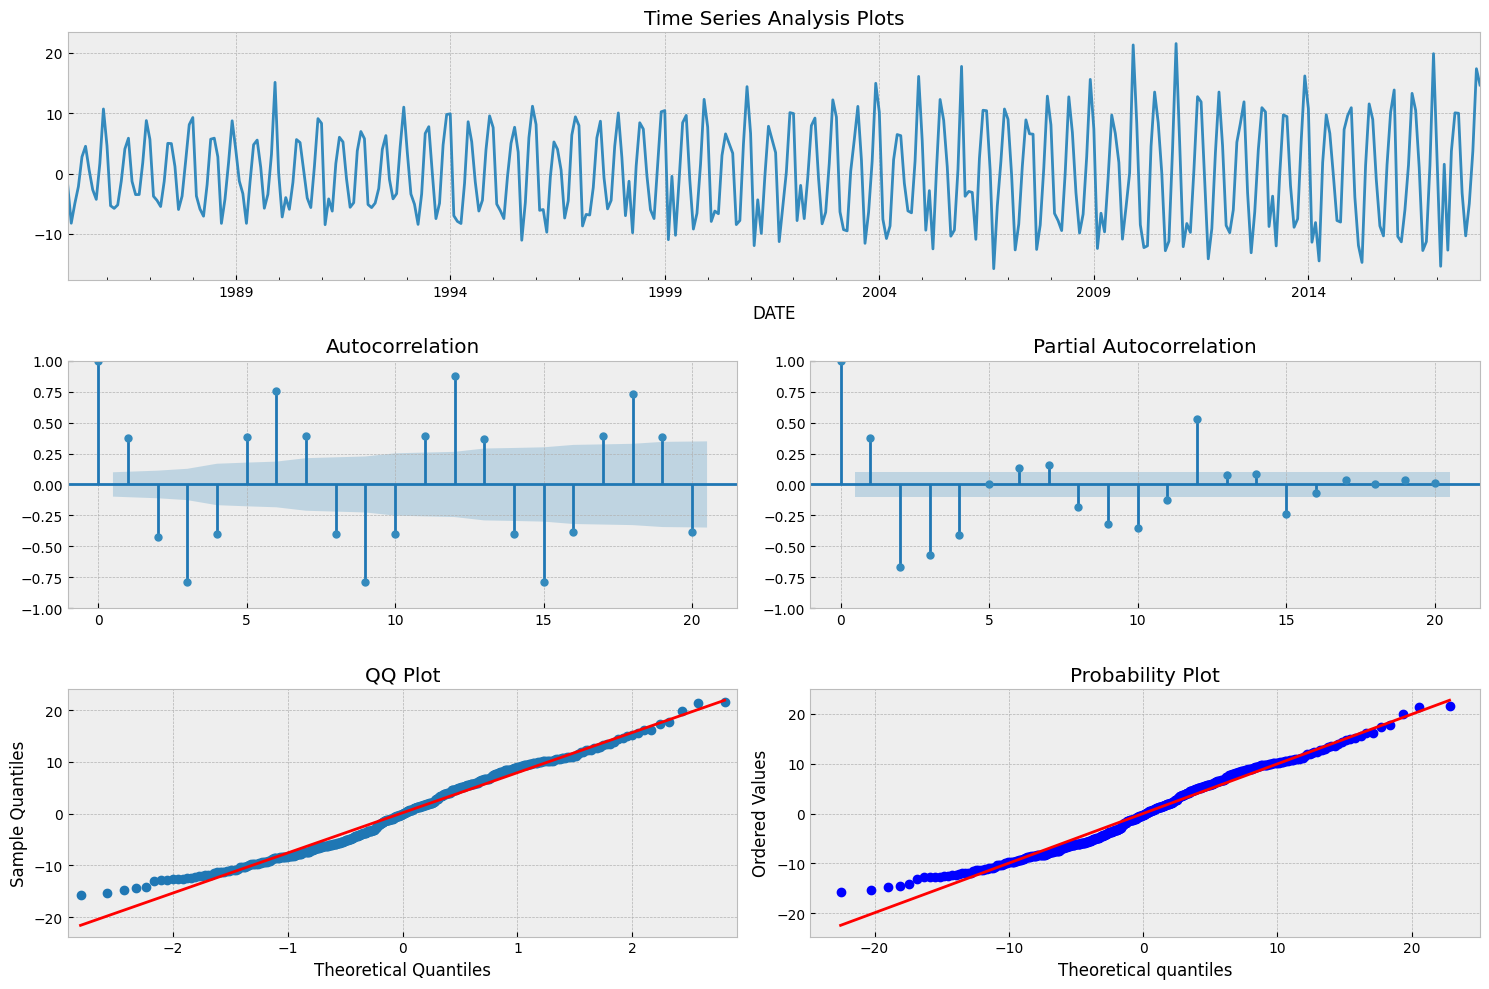

In [58]:
#check ACF, PACF of 1st difference with logarithm
print("1st difference")
tsplot(diff_df, lags=20)

2nd difference


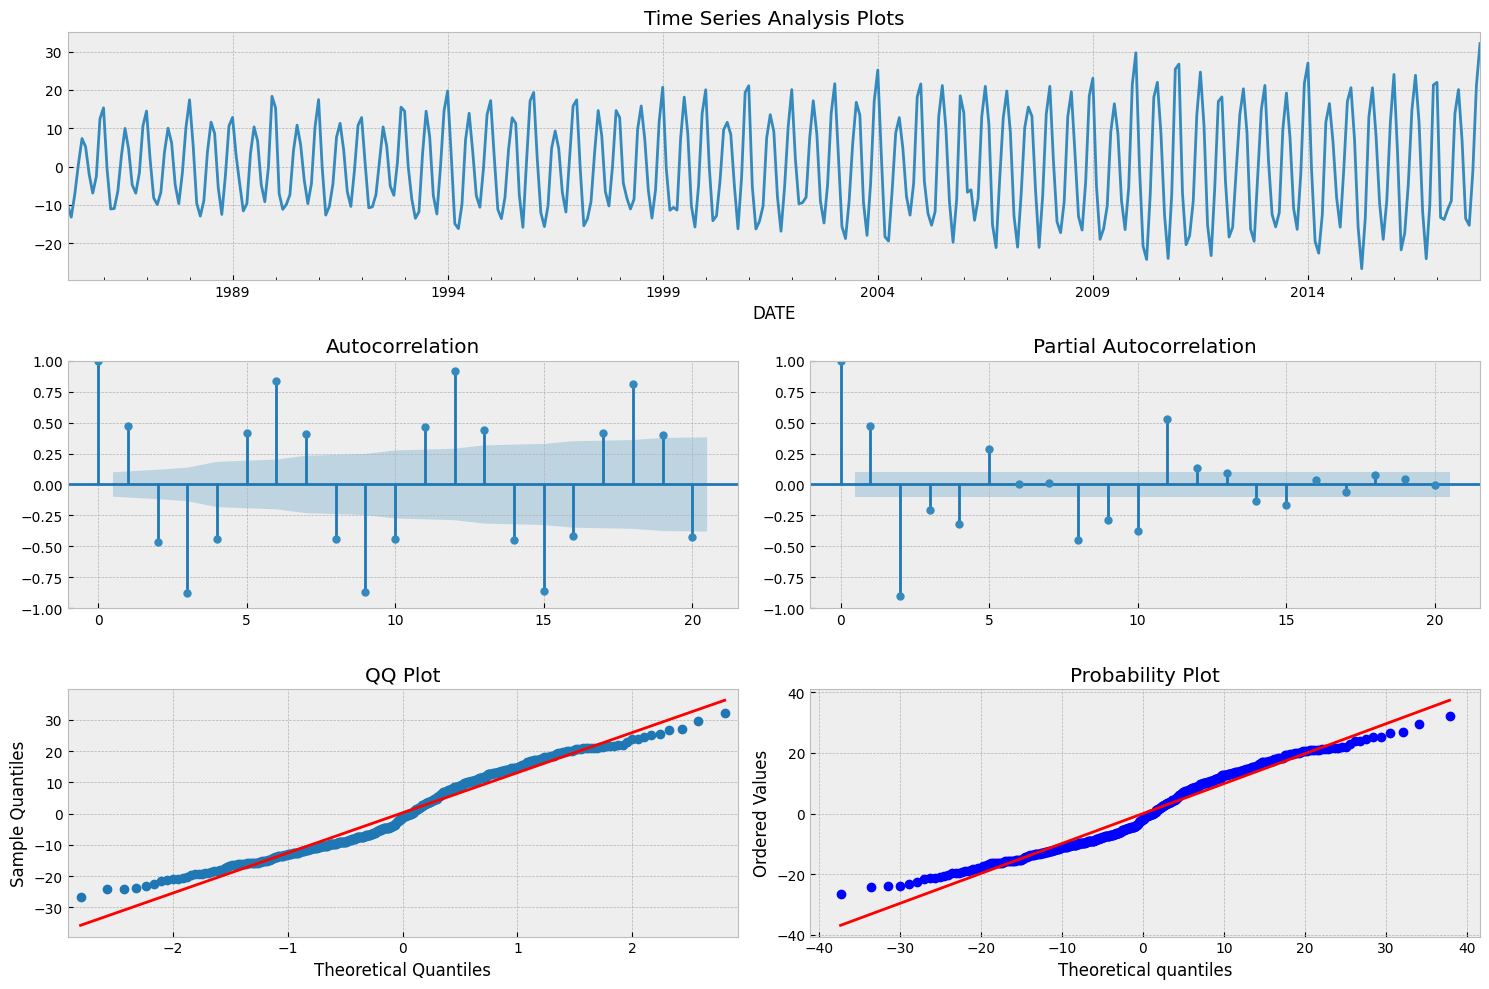

In [59]:
print("2nd difference")
tsplot(diff_2_df, lags=20)

log


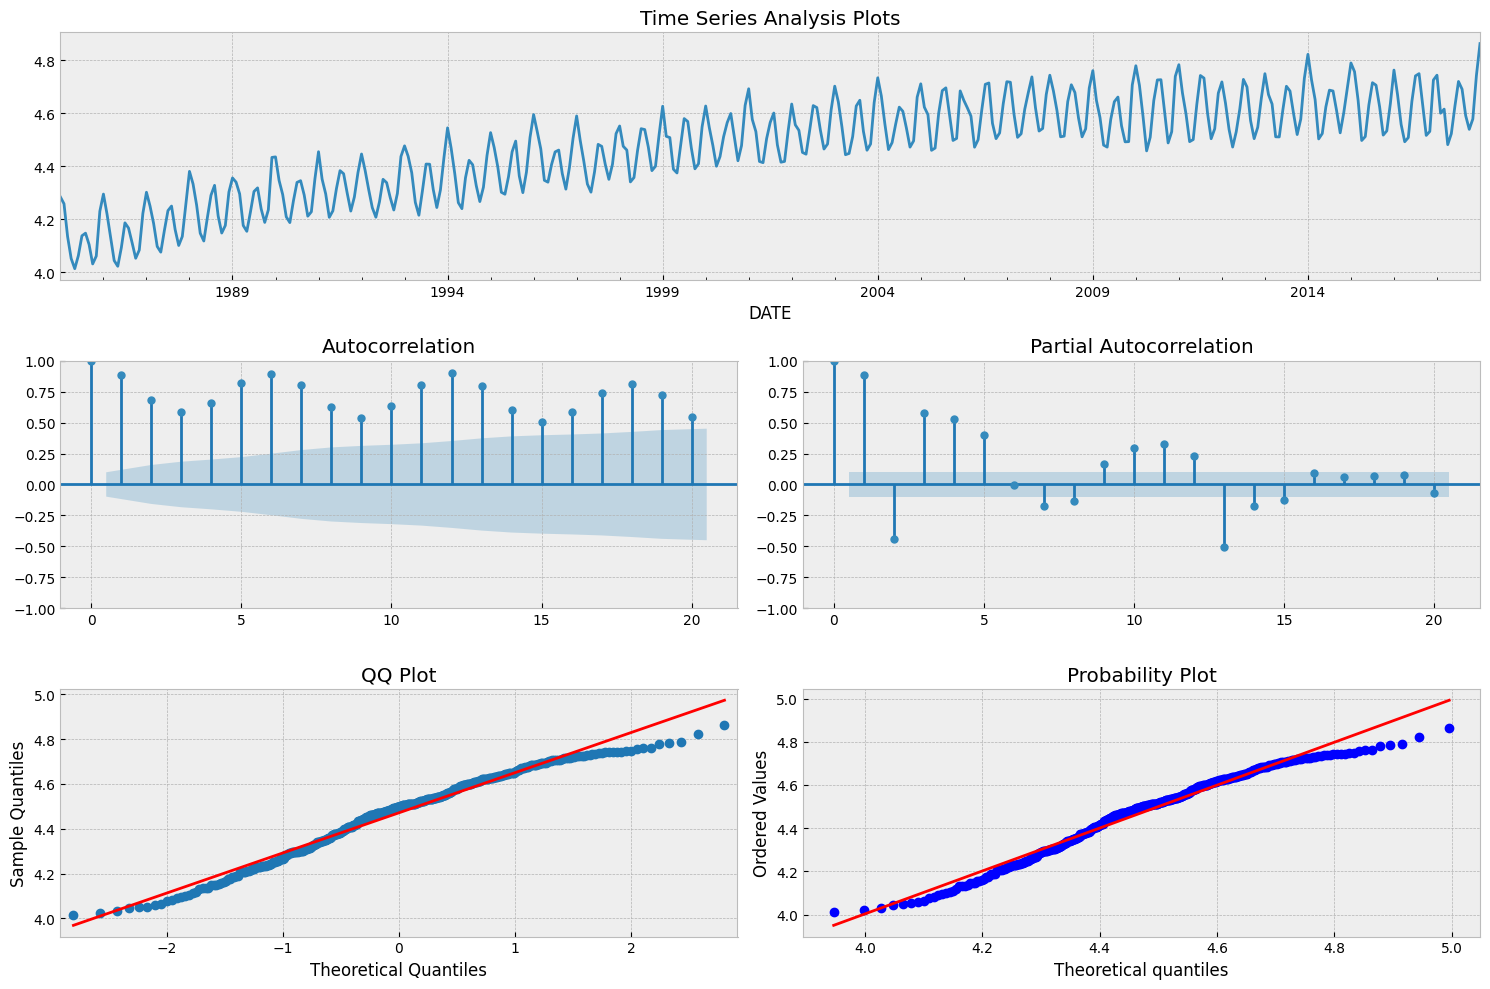

In [60]:
print("log")
tsplot(df_log, lags=20)

1st difference + log


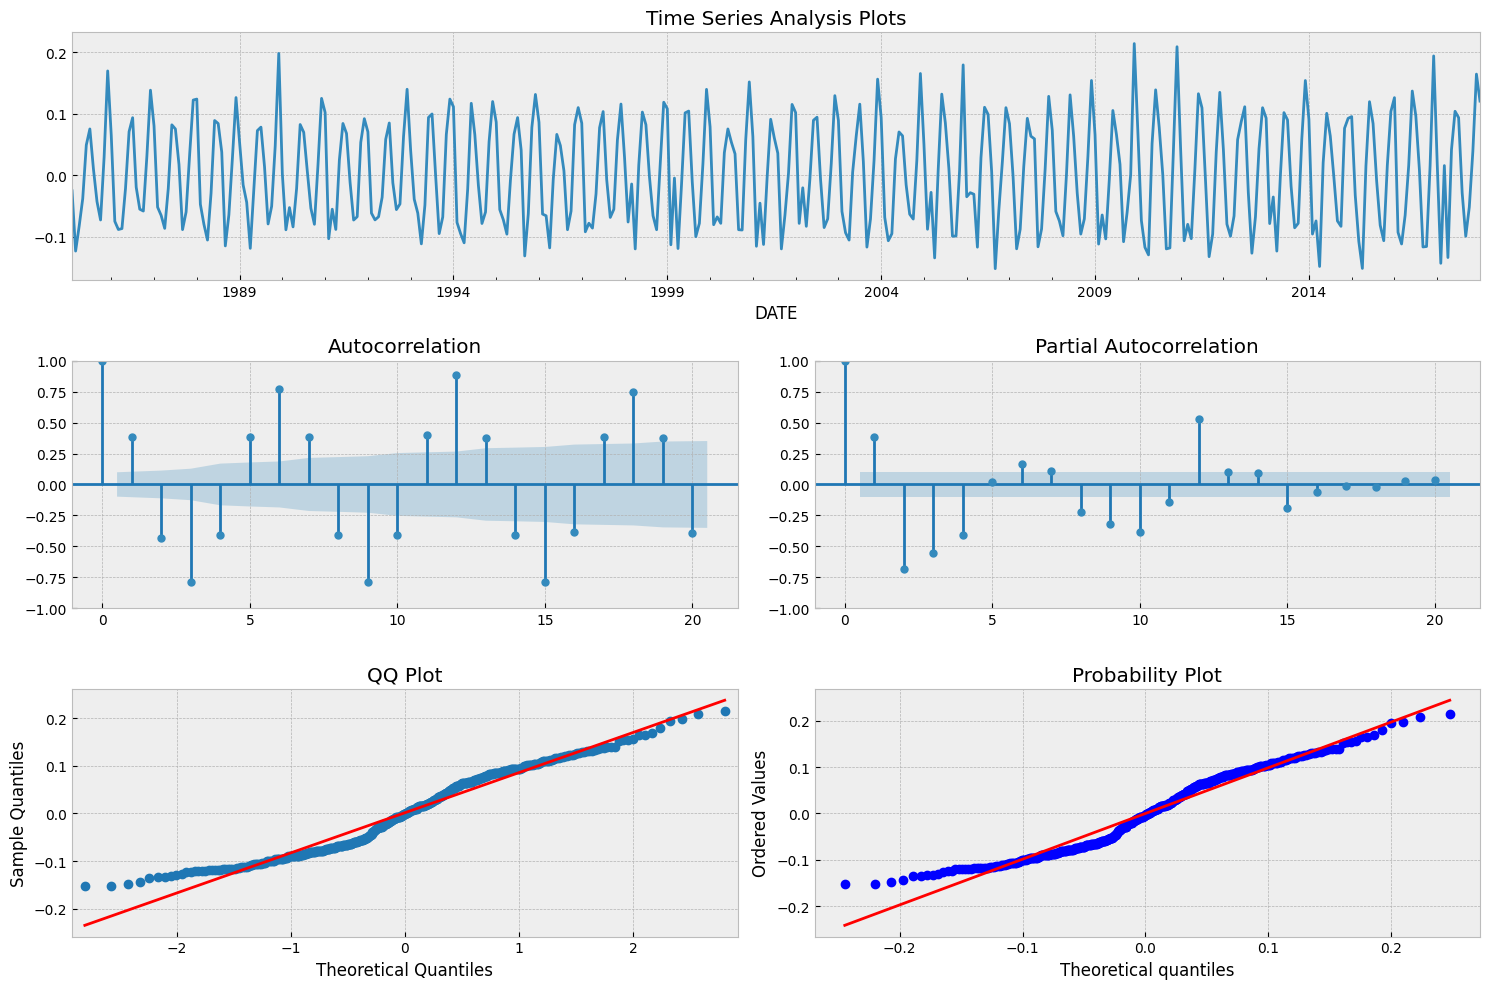

In [61]:
print("1st difference + log")
tsplot(diff_df_log, lags=20)

2st difference + log


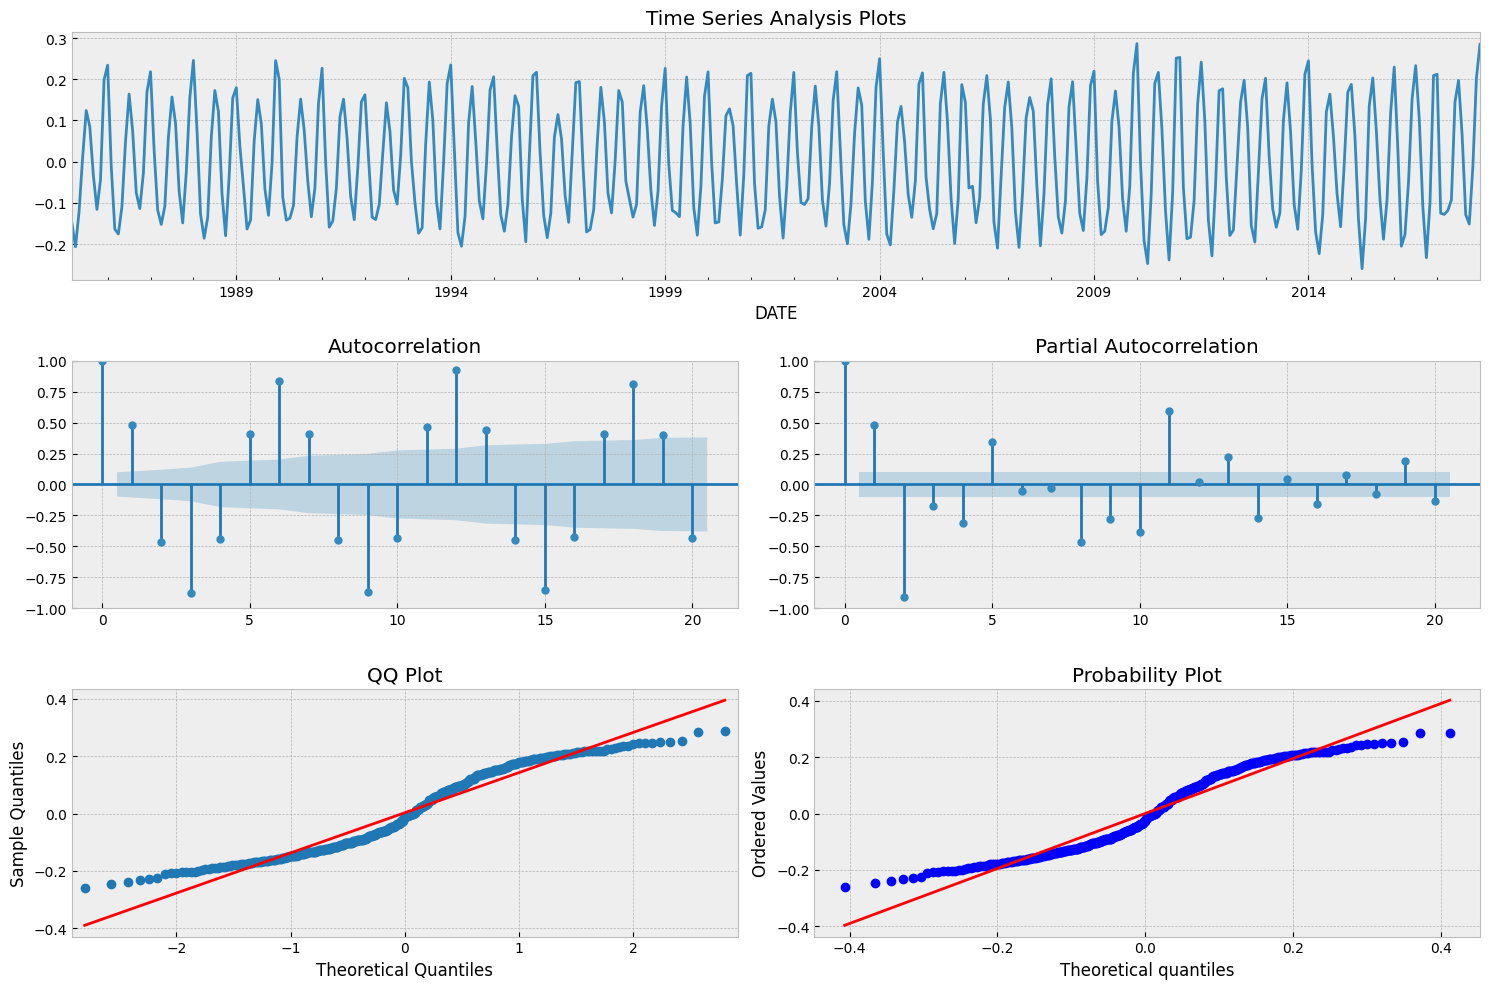

In [62]:
print("2st difference + log")
tsplot(diff_2_df_log, lags=20)

boxcox


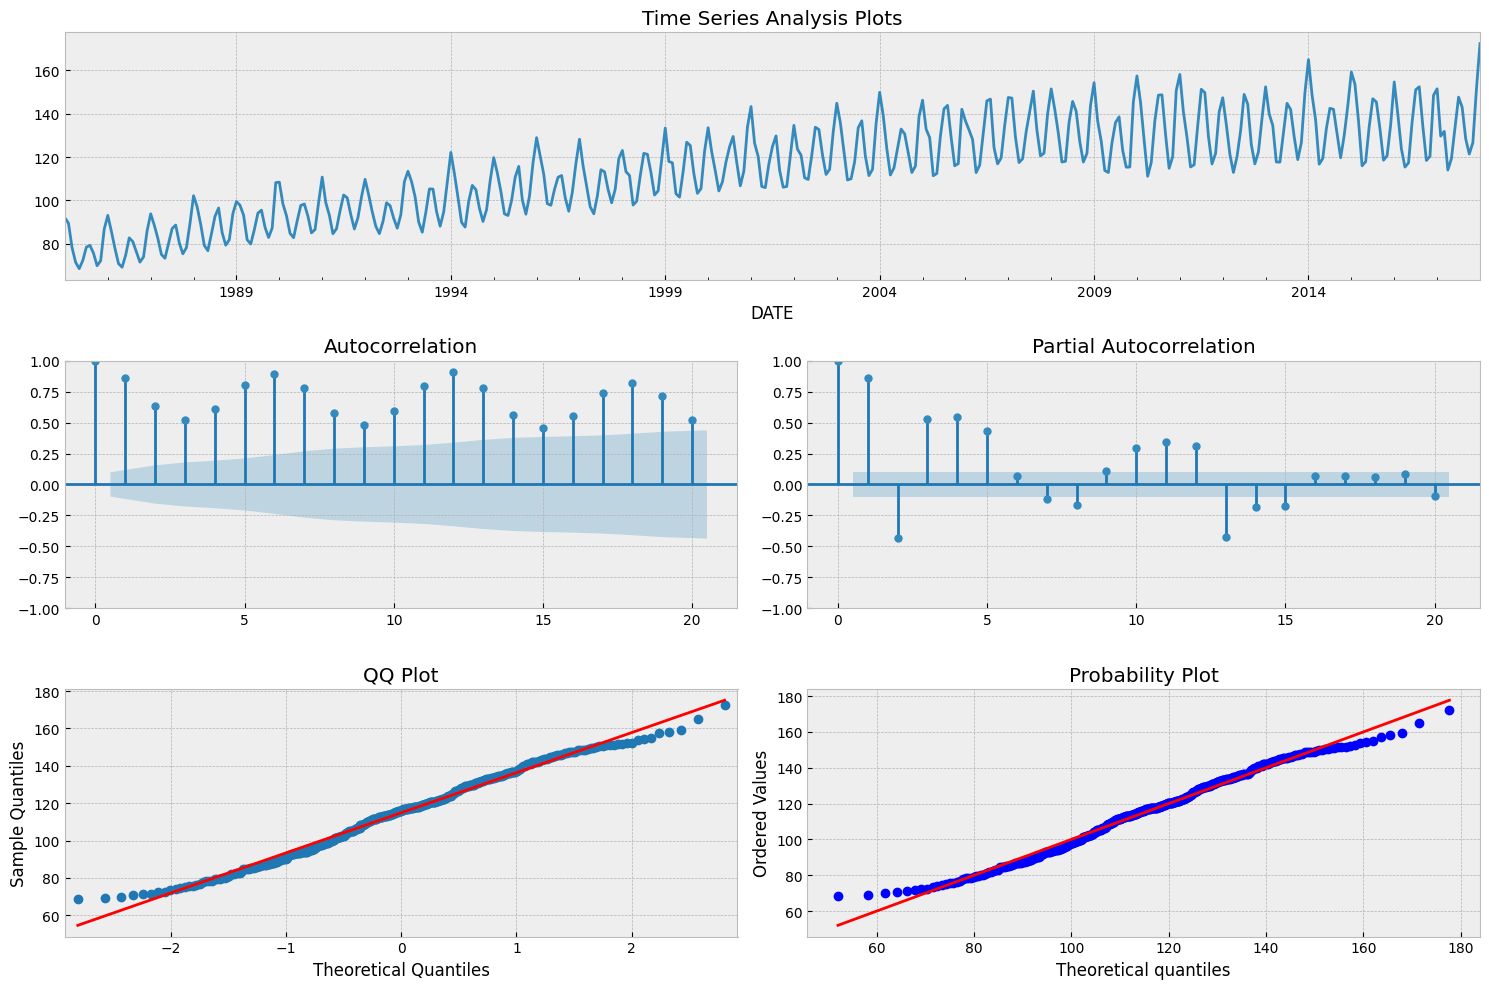

In [63]:
print("boxcox")
tsplot(df_boxcox['value'], lags=20)

1st difference + boxcox


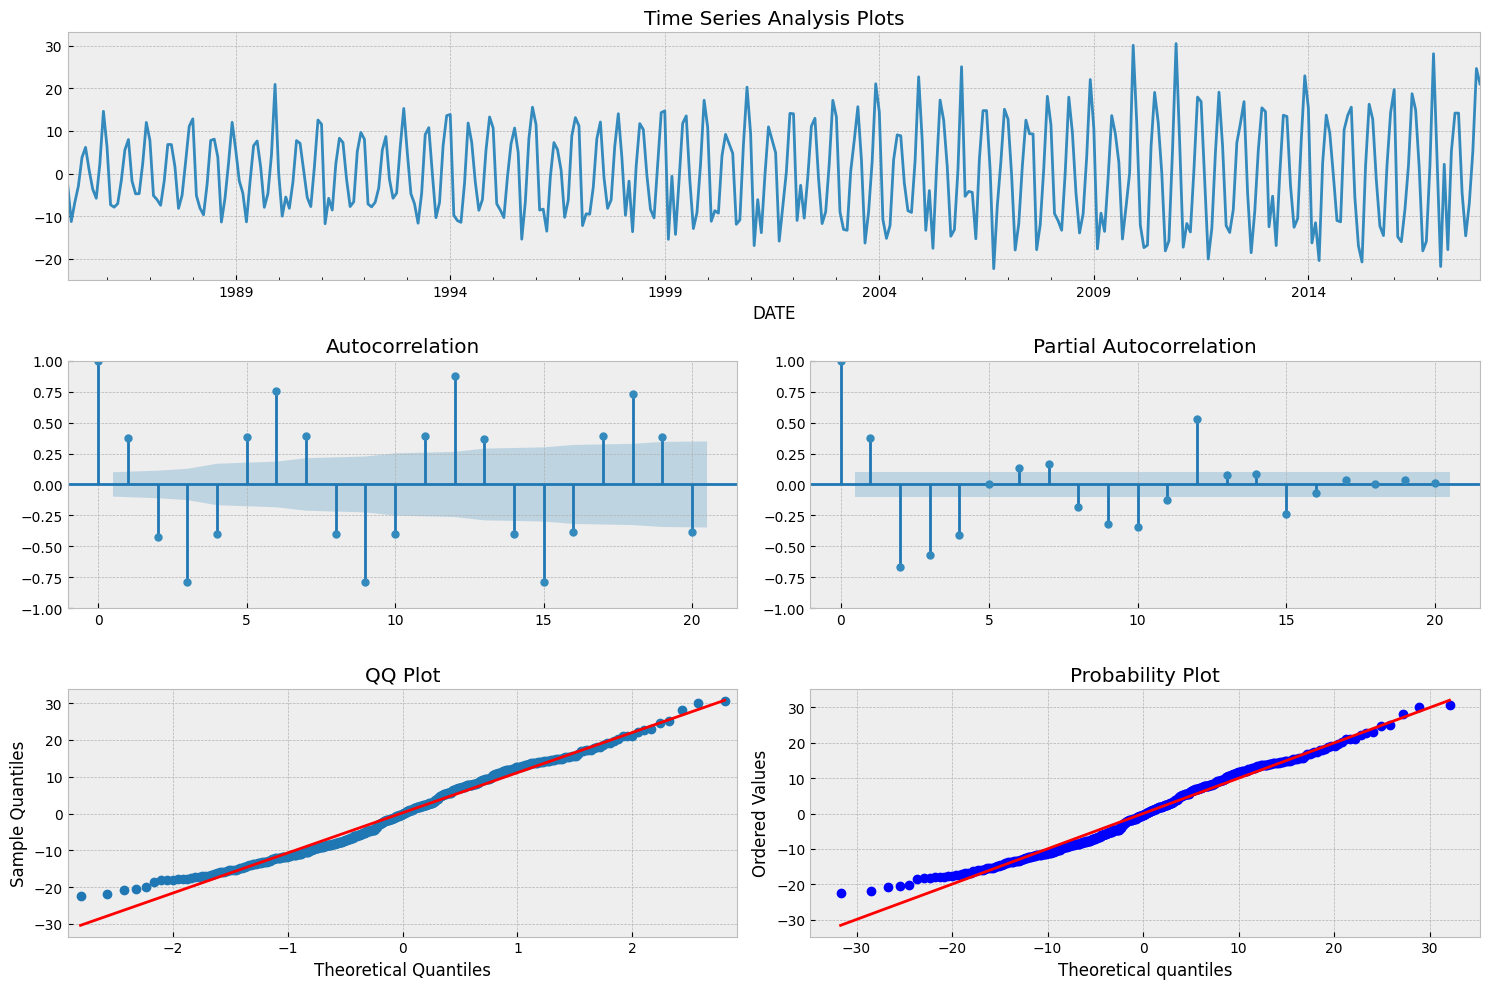

In [64]:
print("1st difference + boxcox")
tsplot(diff_df_boxcox['value'], lags=20)

2nd difference + boxcox


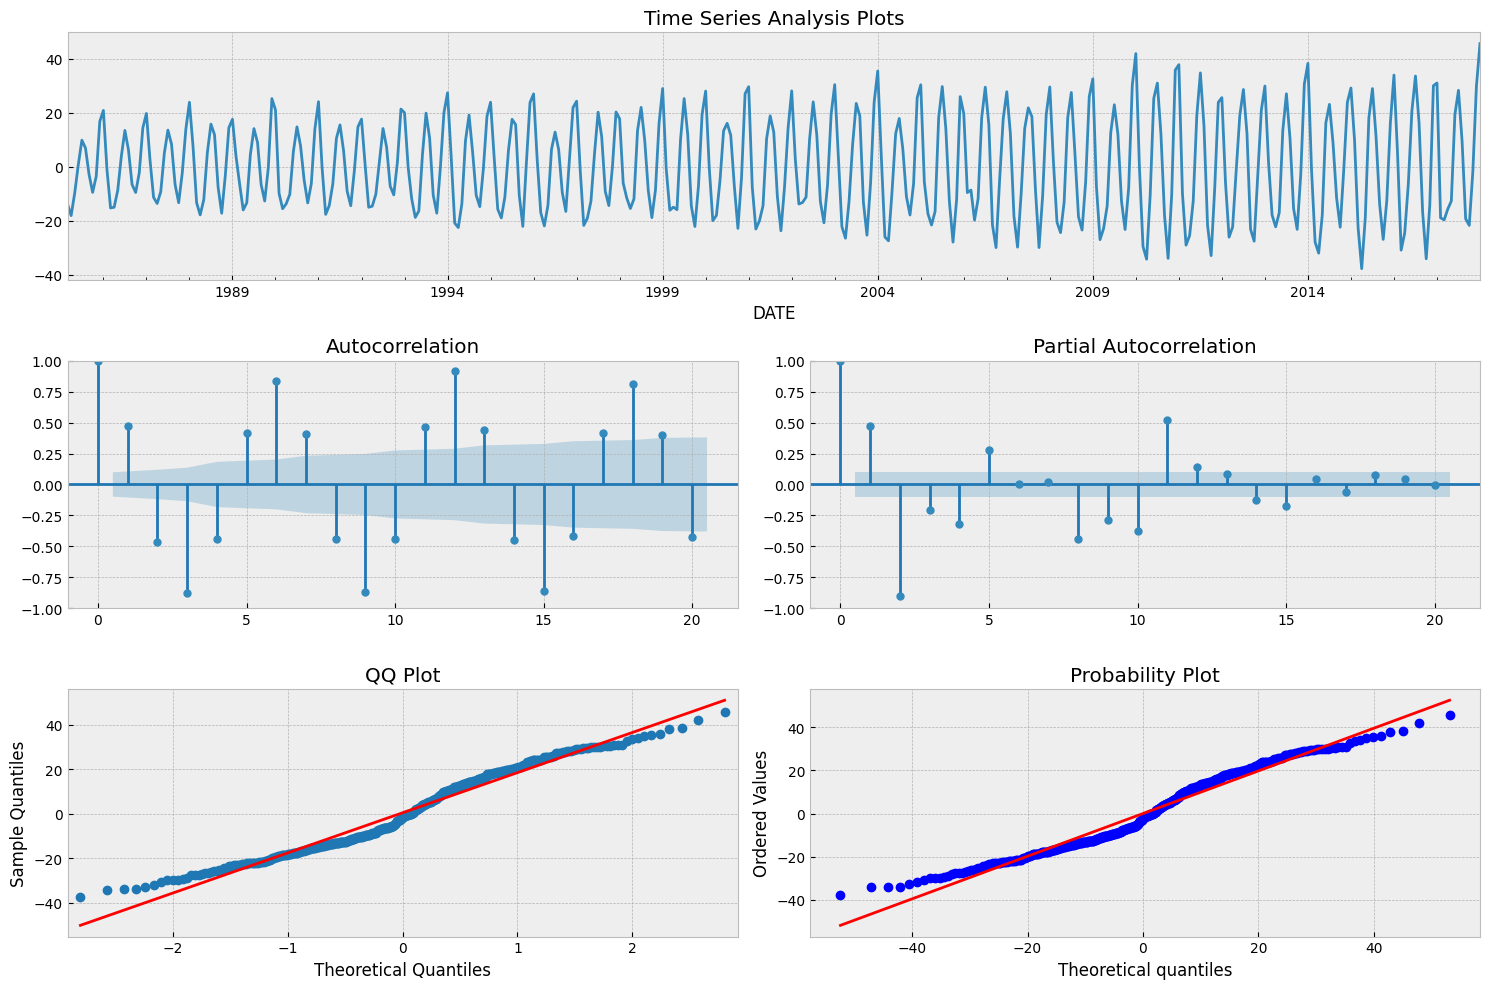

In [65]:
print("2nd difference + boxcox")
tsplot(diff_2_df_boxcox['value'], lags=20)

**Looking the partial autocorrelation function (PACF) plot, it looks like damped *sine wave*. There are too many values outside the blue boundary. It obscures determining p, which is the order of AR(p) model.**

**However, when looking at the autocorrelation function (ACF) plot, it is still in the shape of a fluctuating sine wave, making it difficult to find a clear cut off lag q, which is the order of MA(q) model.**

| Model            | ACF                | PACF  |
|------------------|--------------------|------ |
|MA(q)             |cut off after lag q |Die out|
|AR(p)             |Die out             |Cut off after lag p|
|ARMA(p,q)         |Die out (after q-p) |Die out (after q-p)|


> Die out : exponentially or sin function

* **Example of clearly showing the lag in which ACF and PACF are cut off**

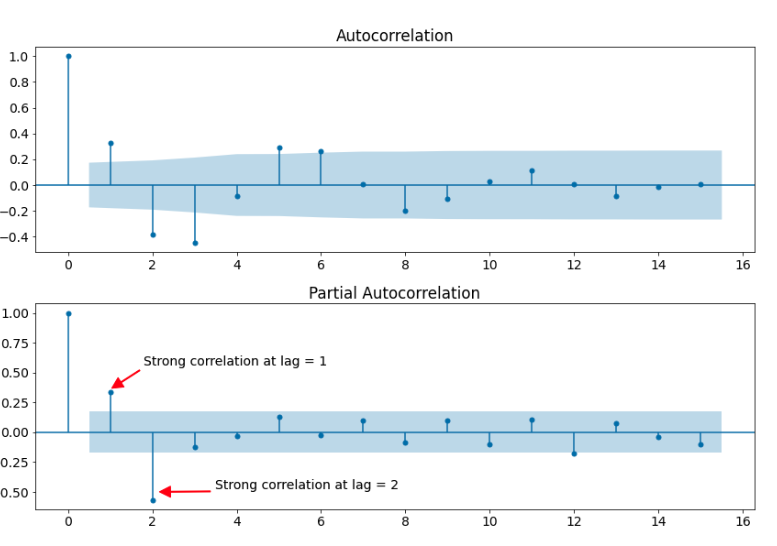

**Therefore, it is ambiguous to determine the order of the AR or MA models by looking only at the ACF and PACF plot of the 1st difference with logarithm data.**

**For now, we will try the AR(1) and MA(1) models and then use the auto_arima function, which finds the optimal order of the models.**

<h3>Estimation for ARIMA model order<h3>

In [25]:
# In ARIMA (p,d,q) model, we try MA(1) first. Also, d=1 because we differenced df_log once.
model = sm.tsa.arima.ARIMA(df_log, order= (0,1,1)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  397
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 487.810
Date:                Wed, 09 Nov 2022   AIC                           -971.619
Time:                        20:24:52   BIC                           -963.656
Sample:                    01-01-1985   HQIC                          -968.464
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6110      0.042     14.718      0.000       0.530       0.692
sigma2         0.0050      0.000     11.711      0.000       0.004       0.006
Ljung-Box (L1) (Q):                   0.66   Jarque-

**The p-value of ar.L1 is lower than 0.05, and AIC is  -971.619**

**Then, let's try AR(1) model.**

In [26]:
# In ARIMA (p,d,q) model, we try AR(1).
model = sm.tsa.arima.ARIMA(df_log, order= (1,1,0)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  397
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 449.985
Date:                Wed, 09 Nov 2022   AIC                           -895.970
Time:                        20:24:52   BIC                           -888.007
Sample:                    01-01-1985   HQIC                          -892.815
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3866      0.060      6.427      0.000       0.269       0.504
sigma2         0.0060      0.001     10.738      0.000       0.005       0.007
Ljung-Box (L1) (Q):                  27.50   Jarque-

**The p value is still lower than 0.05.**

**Plus, AIC and BIC values are lower than the first model.  We need to find the model parameters p,q with the smallest AIC.**


**We can search the optimal parameter p,d,q by auto_arima function.**

**As we distinguish once for the p,q order from 0 to 5, we will specify d=1.**

In [27]:
# The combination is for ARIMA order.

model = pm.auto_arima(df_log, d=1,
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-832.493, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-894.034, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-969.694, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-834.374, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-968.997, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1058.594, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1051.702, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1139.302, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1139.799, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-1155.952, Time=0.73 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-1157.001, Time=0.63 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-1166.167, Time=0.80 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-1208.626, Time=0.94 sec
 ARIMA(2,1,5)(0,0,0)[0] interc

**The optimal p, d , q are 5, 1, 5.**

**Then, we create ARIMA model with p=5, d=1, q=5.**

In [28]:
# create model
model = sm.tsa.arima.ARIMA(df_log, order= (5,1,5))
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  397
Model:                 ARIMA(5, 1, 5)   Log Likelihood                 750.141
Date:                Wed, 09 Nov 2022   AIC                          -1478.282
Time:                        20:25:09   BIC                          -1434.487
Sample:                    01-01-1985   HQIC                         -1460.932
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7986      1.619      0.493      0.622      -2.375       3.972
ar.L2         -0.5517      2.267     -0.243      0.808      -4.994       3.891
ar.L3         -0.2057      2.069     -0.099      0.9

**All p-values are greater than 0.05. However, AIC and BIC is lowest compared with above results.**

<h3>Residual Analysis<h3>

| Test      |Good Fit                | 
|------------------|--------------------|
|Standardized residual           |There are no obvious patterns in the residuals|
|Histogram plus kde estimate          |The KDE curve should be very similar to the normal distribution           |
|Normal Q-Q        |Most of the data points should lie on the straight line |
|Correlogram| 95% of correlations for lag greater than zero should not be significant|

**Now, let's inspect the residuals of the model.**

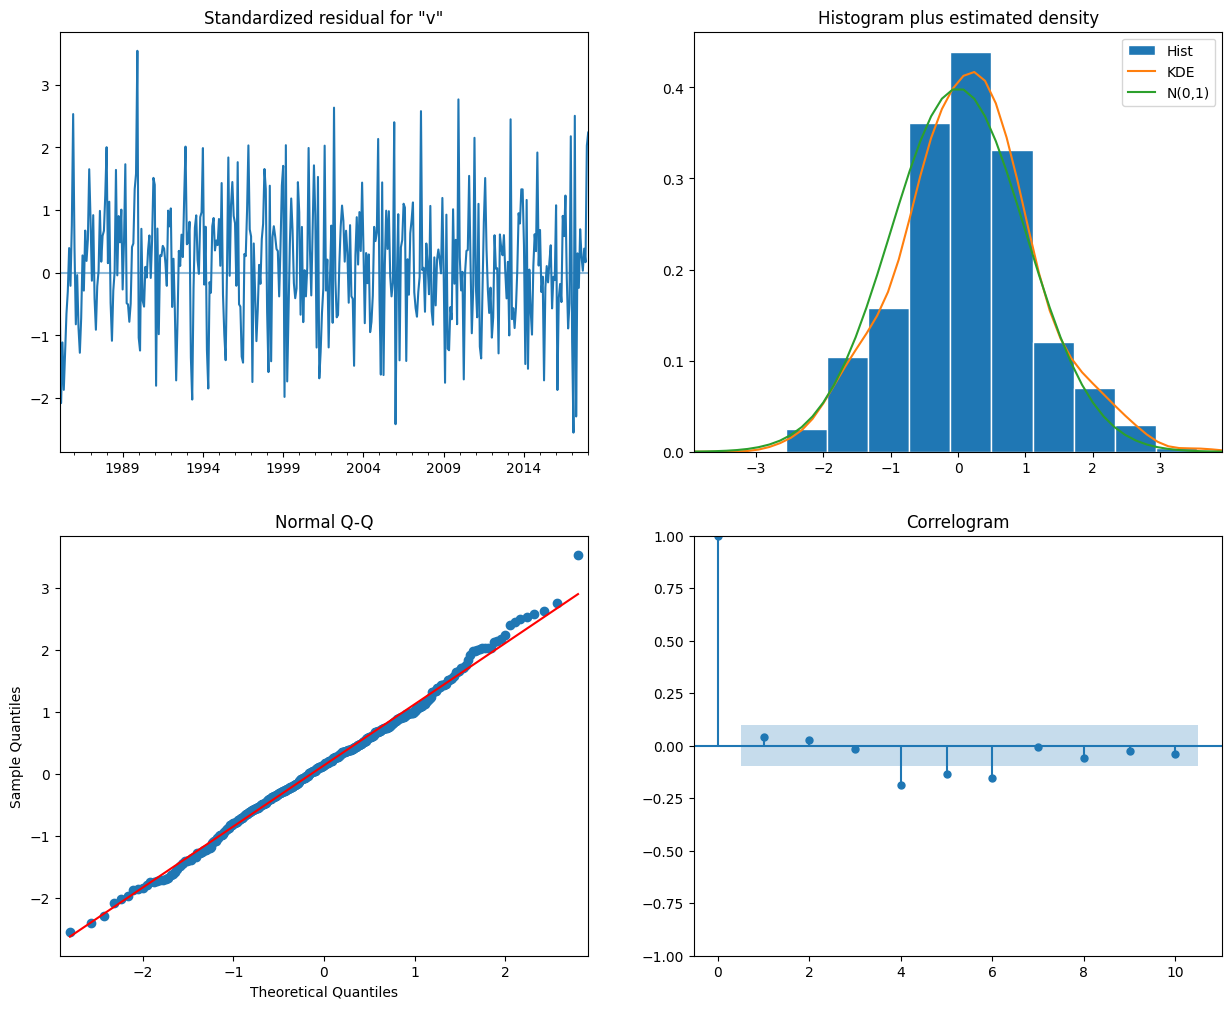

In [29]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

**Looking at the ACF plots of model residuals, there are some values outside the range of errors in lag 5,6,7. This is probably due to the fact that we have not removed the seasonality of the data.**

**Also, looking the histogram and density of the residuals, it is slightly skewed to the right than the normal distribution and has a slightly higher kurtosis.**

**When looking at the Q-Q plot, almost all the residuals are on the red line, but some points are off the line at either end.**

**To sum up the residual analysis diagnostic plots, the residuals of model looks stationary. So we can say that our model is fitted quite well.**

**In order to fit the model better, it is necessary to consider the characteristics of the seasonality and trends of the data.**

<h3>Forecasting with our model<h3>

**We will now divide our dataset into training/test sets to see if the model predicts next month electric production.**

In [30]:
#Split data as train set, test set
train_set, test_set = train_test_split(df_log, test_size = 0.2, shuffle=False)

In [31]:
print(train_set)
print(test_set)

DATE
1985-01-01    4.283658
1985-02-01    4.258049
1985-03-01    4.134369
1985-04-01    4.051287
1985-05-01    4.013046
                ...   
2011-01-01    4.783216
2011-02-01    4.676330
2011-03-01    4.596158
2011-04-01    4.492654
2011-05-01    4.500585
Name: value, Length: 317, dtype: float64
DATE
2011-06-01    4.632984
2011-07-01    4.742379
2011-08-01    4.732647
2011-09-01    4.599868
2011-10-01    4.503764
                ...   
2017-09-01    4.591227
2017-10-01    4.539177
2017-11-01    4.578168
2017-12-01    4.742505
2018-01-01    4.862945
Name: value, Length: 80, dtype: float64


In [32]:
# Search parameters for train set
model = pm.auto_arima(train_set, d=1, seasonal=False, #consider seasonality
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-680.073, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-728.649, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-792.401, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-682.050, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-791.083, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-864.933, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-924.753, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-923.928, Time=0.50 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-940.353, Time=0.51 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-936.894, Time=0.61 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-966.254, Time=0.70 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-984.044, Time=0.76 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=-1172.053, Time=0.81 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   :

In [33]:
# create model for train set
model = sm.tsa.arima.ARIMA(train_set, order= (5,1,5))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  317
Model:                 ARIMA(5, 1, 5)   Log Likelihood                 616.249
Date:                Wed, 09 Nov 2022   AIC                          -1210.498
Time:                        20:25:25   BIC                          -1169.185
Sample:                    01-01-1985   HQIC                         -1193.994
                         - 05-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3317      0.313      1.059      0.290      -0.282       0.946
ar.L2          0.1676      0.294      0.570      0.569      -0.409       0.744
ar.L3         -0.6155      0.181     -3.405      0.0

In [34]:
# get the forcasted value from our model
y_pred = results.get_forecast(len(test_set))

In [35]:
pred = y_pred
pred_value = pred.predicted_mean

#upper bound
pred_ub = pred.conf_int().iloc[:,0]

#lower bound
pred_lb = pred.conf_int().iloc[:,1]
pred_index = list(test_set.index)
r2 = r2_score(test_set, pred_value)

In [36]:
pred_value

2011-06-01    4.628068
2011-07-01    4.701849
2011-08-01    4.663764
2011-09-01    4.547315
2011-10-01    4.477758
                ...   
2017-09-01    4.556711
2017-10-01    4.493447
2017-11-01    4.542051
2017-12-01    4.653713
2018-01-01    4.716600
Freq: MS, Name: predicted_mean, Length: 80, dtype: float64

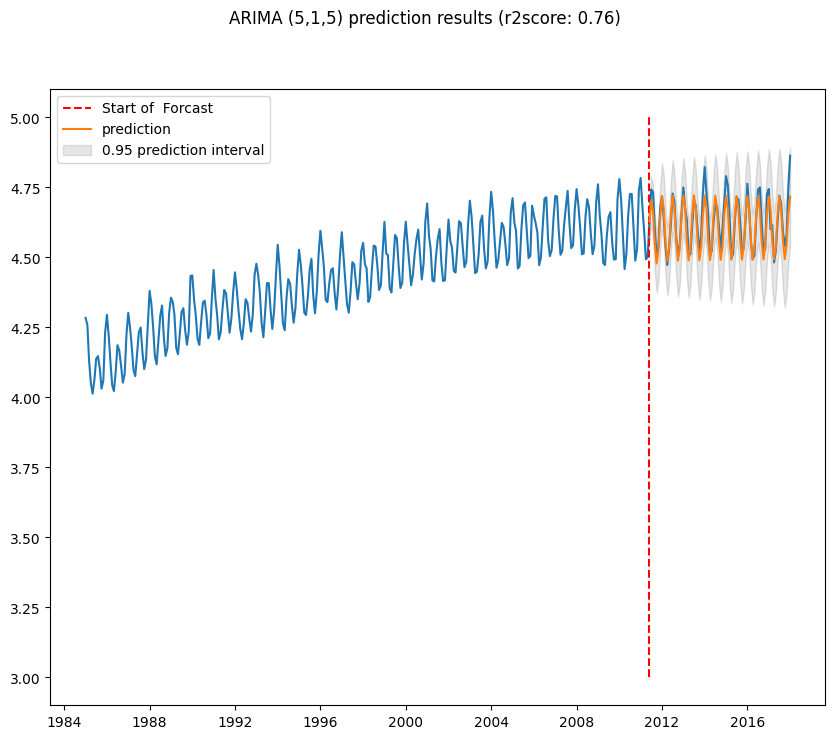

In [37]:
fig, ax= plt.subplots(figsize=(10,8))
ax.plot(df_log.index, df_log)
ax.vlines(pd.to_datetime('2011-06-01'), 3,5, linestyle ='--', color='r',
         label = 'Start of  Forcast')
ax.plot(pred_index, pred_value, label='prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k',
               alpha= 0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA (5,1,5) prediction results (r2score: {round(r2,2)})')
plt.show()

**So far, we have distinguished the stationarity through ACF and PACF of one time series dataset, made it stationary through difference, and implemented a traditional time series model to predict future data.**